In [28]:
import os
import sys
import struct

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.cluster import KMeans, spectral_clustering, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score
from copy import deepcopy


In [51]:
root_path = "/home/g.esposito/sc2-benchmark"
layer_confs = [file_path for file_path in os.listdir(root_path) if file_path.startswith("FSIM_W_hpc_sem_L")]

general_report = pd.DataFrame([])
detailed_report = pd.DataFrame([])

for layer_conf in layer_confs:
    configurations_log = os.path.join(root_path, layer_conf)

    # to_iterate = [log for log in os.listdir(configurations_log) if os.path.isdir(configurations_log)]
    # print(to_iterate)
    for cnf in os.listdir(configurations_log):
        cnf_path = os.path.join(configurations_log, cnf) 
        if os.path.isdir(cnf_path):
            # print(os.path.isdir(configurations_log))
            # print(cnf)
            for file in os.listdir(cnf_path):
                report_path = os.path.join(cnf_path, file)
                # print(report_path)
                if file == "fsim_full_report.csv":
                    report = pd.read_csv(report_path)

                    report['conf_detail'] = cnf.split("_")[0] if cnf.split("_")[0] != "cnf77" else "teacher_cnf"

                    report['bit_faulty_position'] = np.log2(report['bitmask'])

                    indices = report.query("mask_Crit==0 and mask_SDC==0 and mask_Masked == 0").index
                    for idx in indices:
                        report.loc[idx, 'Crit_perc'] = 100
                        report.loc[idx, 'SDC_perc'] = 0
                        report.loc[idx, 'masked_perc'] = 100

                    report.drop(columns=['kernel.1','channel.1','row.1','col.1','BitMask', 'Unnamed: 0'], inplace=True)
                    # print(report.columns)

                    tot_mask_per_fault = report['mask_Crit'] + report['mask_SDC'] + report['mask_Masked']
                    # for val in tot_mask_per_fault:
                    #     if val == 0:
                    #         print('queste sono tutte critiche')
                    report['Crit_perc'] = (report['mask_Crit'] / tot_mask_per_fault)*100
                    report['SDC_perc'] = (report['mask_SDC'] / tot_mask_per_fault)*100
                    report['masked_perc'] = (report['mask_Masked'] / tot_mask_per_fault)*100

                    report['global_fault_f1@1'] = report['global_fault_f1@1']*100

                    general_report = pd.concat([general_report, report], axis=0, ignore_index=True)
                
                if file == "Faulty_masks_report.csv":
                    # print('porcodio')
                    report = pd.read_csv(report_path)

                    report['conf_detail'] = cnf.split("_")[0] if cnf.split("_")[0] != "cnf77" else "teacher_cnf"
                    report['bit_faulty_position'] = np.log2(report['bitmask'])

                    report.drop(columns=['Unnamed: 0'], inplace=True)
                    detailed_report = pd.concat([detailed_report, report], axis=0, ignore_index=True)

general_report.columns



Index(['layer', 'kernel', 'channel', 'row', 'col', 'bitmask',
       'global_gold_acc', 'global_gold_f1@1', 'global_fault_acc',
       'global_fault_f1@1', 'mask_Crit', 'mask_SDC', 'mask_Masked', 'Layer',
       'Ffree_Weight', 'Faulty_weight', 'Abs_error', 'conf_detail',
       'bit_faulty_position', 'Crit_perc', 'SDC_perc', 'masked_perc'],
      dtype='object')

In [52]:
# Define the desired order of the categories
desired_order = ['cnf1', 'cnf2', 'cnf3', 'cnf6', 'cnf9', 'cnf12', 'teacher_cnf']

# Sort the data by the categorical variable
general_report = general_report.sort_values(by='conf_detail')
general_report['conf_detail'] = general_report['conf_detail'].astype('category')
general_report['conf_detail'].cat.reorder_categories(desired_order, inplace=True)

# Sort the data by the categorical variable
detailed_report = detailed_report.sort_values(by='conf_detail')
detailed_report['conf_detail'] = detailed_report['conf_detail'].astype('category')
detailed_report['conf_detail'].cat.reorder_categories(desired_order, inplace=True)

<ipython-input-52-c4ee35f254e3>:7: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  general_report['conf_detail'].cat.reorder_categories(desired_order, inplace=True)
<ipython-input-52-c4ee35f254e3>:12: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  detailed_report['conf_detail'].cat.reorder_categories(desired_order, inplace=True)


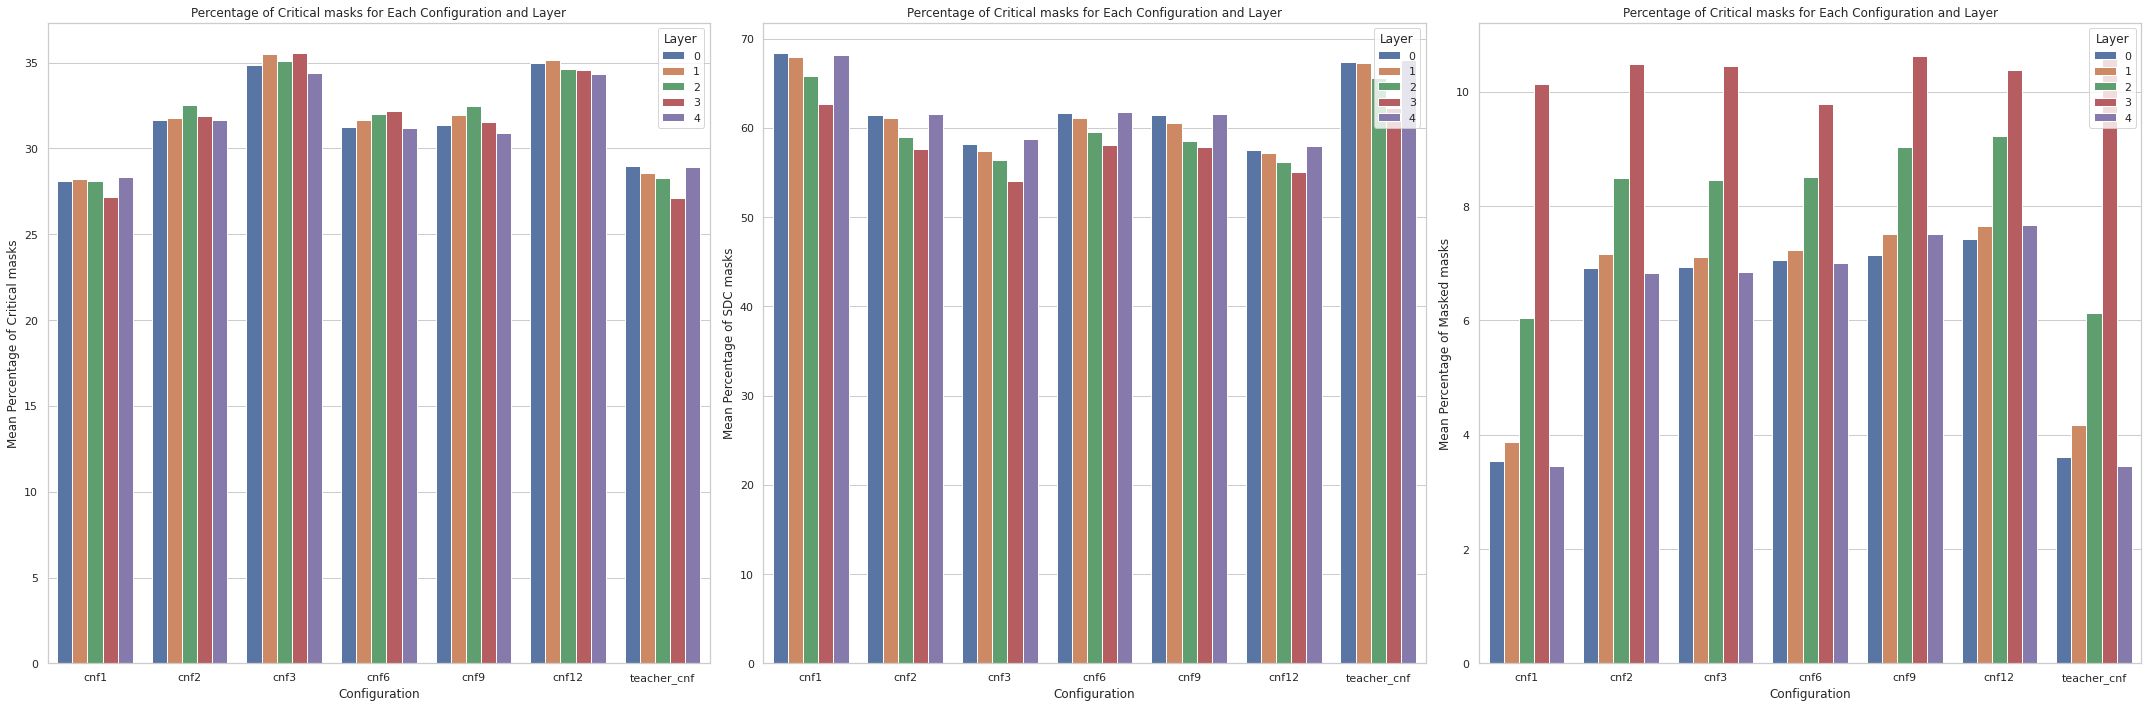

In [53]:
mean_percentages_crit = general_report.groupby(['conf_detail', 'layer'])['Crit_perc'].mean().reset_index()
mean_percentages_sdc = general_report.groupby(['conf_detail', 'layer'])['SDC_perc'].mean().reset_index()
mean_percentages_masked = general_report.groupby(['conf_detail', 'layer'])['masked_perc'].mean().reset_index()

fig, ax = plt.subplots(1,3, figsize=(30,10))
sns.set(style='whitegrid')
sns.barplot(x='conf_detail', y='Crit_perc', hue='layer', data=mean_percentages_crit, ax = ax[0])
ax[0].set_xlabel('Configuration')
ax[0].set_ylabel('Mean Percentage of Critical masks')
ax[0].set_title('Percentage of Critical masks for Each Configuration and Layer')
ax[0].legend(title='Layer', loc='upper right')

sns.set(style='whitegrid')
sns.barplot(x='conf_detail', y='SDC_perc', hue='layer', data=mean_percentages_sdc, ax = ax[1])
ax[1].set_xlabel('Configuration')
ax[1].set_ylabel('Mean Percentage of SDC masks')
ax[1].set_title('Percentage of Critical masks for Each Configuration and Layer')
ax[1].legend(title='Layer', loc='upper right')

sns.set(style='whitegrid')
sns.barplot(x='conf_detail', y='masked_perc', hue='layer', data=mean_percentages_masked, ax = ax[2])
ax[2].set_xlabel('Configuration')
ax[2].set_ylabel('Mean Percentage of Masked masks')
ax[2].set_title('Percentage of Critical masks for Each Configuration and Layer')
ax[2].legend(title='Layer', loc='upper right')
plt.tight_layout()


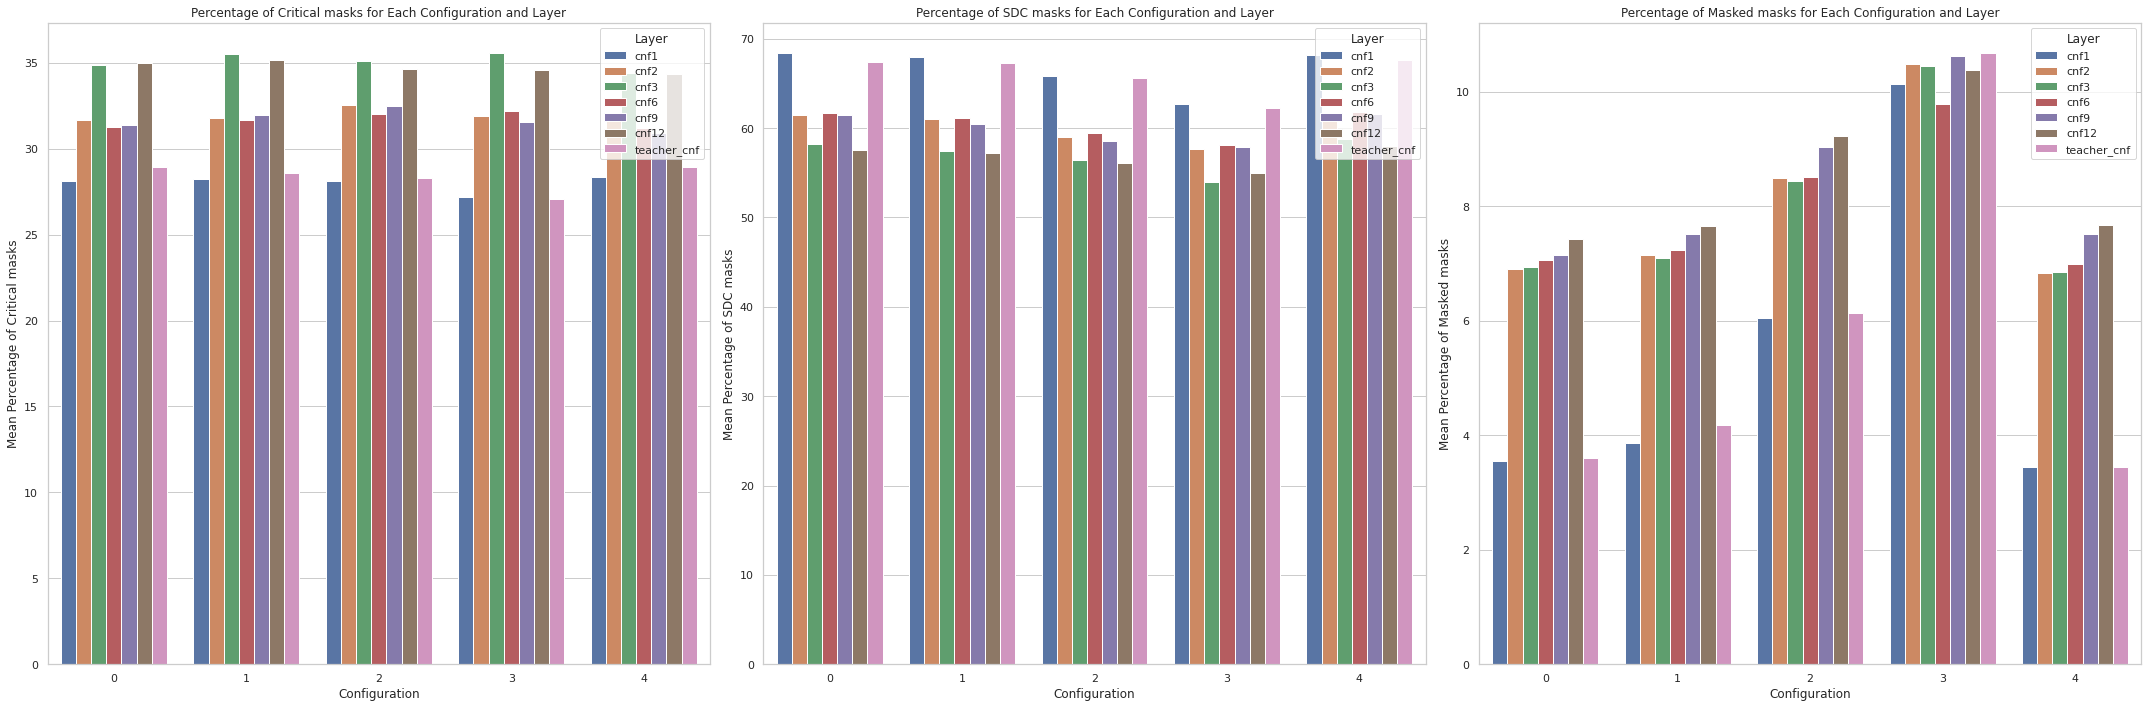

In [54]:
mean_percentages_crit = general_report.groupby(['conf_detail', 'layer'])['Crit_perc'].mean().reset_index()
mean_percentages_sdc = general_report.groupby(['conf_detail', 'layer'])['SDC_perc'].mean().reset_index()
mean_percentages_masked = general_report.groupby(['conf_detail', 'layer'])['masked_perc'].mean().reset_index()

fig, ax = plt.subplots(1,3, figsize=(30,10))
sns.set(style='whitegrid')
sns.barplot(x='layer', y='Crit_perc', hue='conf_detail', data=mean_percentages_crit, ax = ax[0])
ax[0].set_xlabel('Configuration')
ax[0].set_ylabel('Mean Percentage of Critical masks')
ax[0].set_title('Percentage of Critical masks for Each Configuration and Layer')
ax[0].legend(title='Layer', loc='upper right')

sns.set(style='whitegrid')
sns.barplot(x='layer', y='SDC_perc', hue='conf_detail', data=mean_percentages_sdc, ax = ax[1])
ax[1].set_xlabel('Configuration')
ax[1].set_ylabel('Mean Percentage of SDC masks')
ax[1].set_title('Percentage of SDC masks for Each Configuration and Layer')
ax[1].legend(title='Layer', loc='upper right')

sns.set(style='whitegrid')
sns.barplot(x='layer', y='masked_perc', hue='conf_detail', data=mean_percentages_masked, ax = ax[2])
ax[2].set_xlabel('Configuration')
ax[2].set_ylabel('Mean Percentage of Masked masks')
ax[2].set_title('Percentage of Masked masks for Each Configuration and Layer')
ax[2].legend(title='Layer', loc='upper right')
plt.tight_layout()

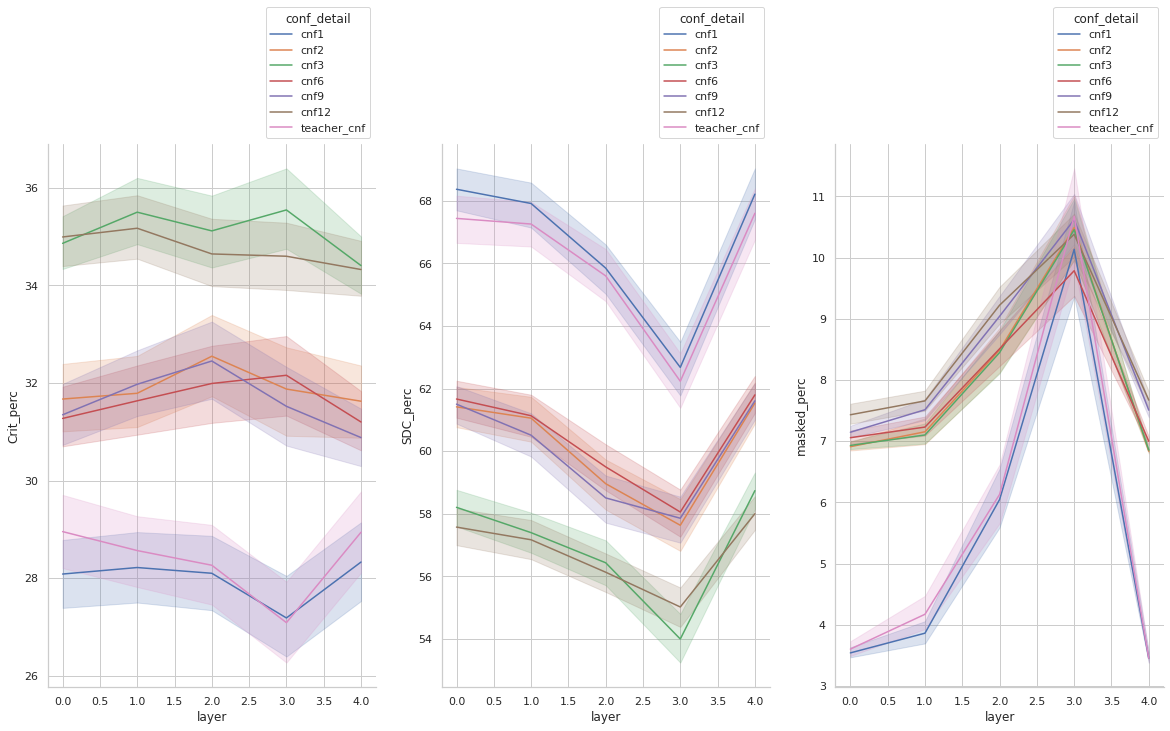

In [55]:
fig, ax = plt.subplots(1,3, figsize=(20,10))
sns.despine(fig)
# ax[0].grid()
sns.lineplot(data=general_report, x='layer', y='Crit_perc', ax=ax[0], hue ='conf_detail')
sns.move_legend(ax[0], "lower right", bbox_to_anchor=(1, 1))
# ax[1].grid()
sns.lineplot(data=general_report, x='layer', y='SDC_perc', ax=ax[1],hue ='conf_detail')
sns.move_legend(ax[1], "lower right", bbox_to_anchor=(1, 1))
# ax[2].grid()
sns.lineplot(data=general_report, x='layer', y='masked_perc', ax=ax[2], hue ='conf_detail')
sns.move_legend(ax[2], "lower right", bbox_to_anchor=(1, 1))

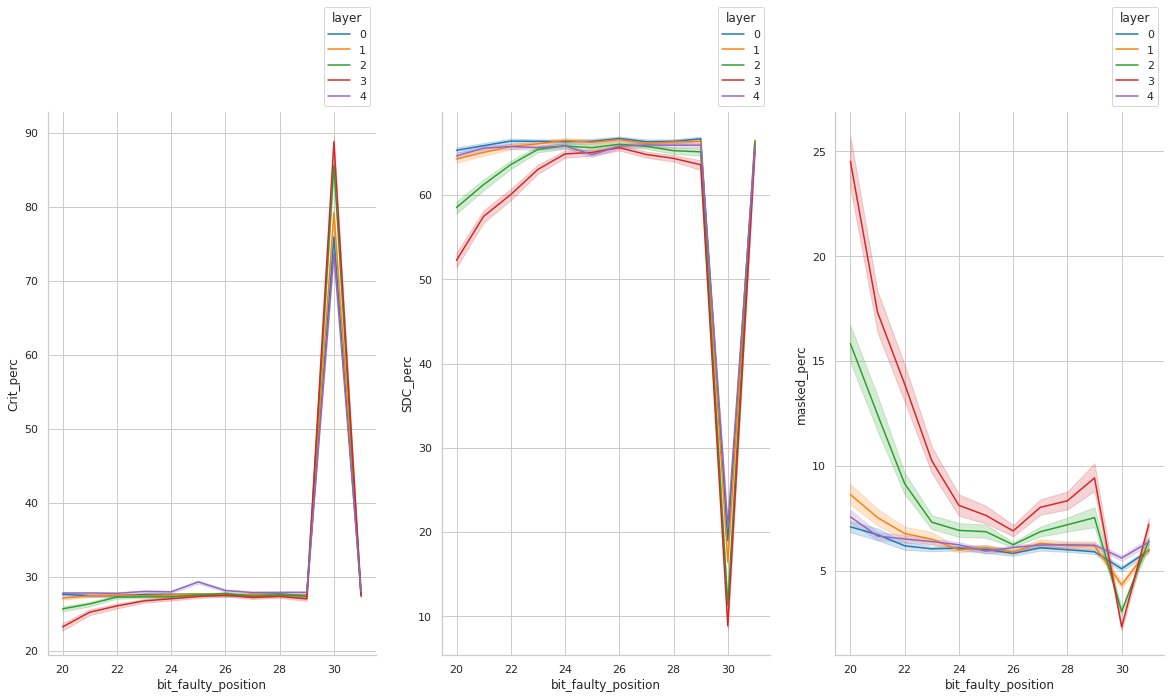

In [56]:
fig, ax = plt.subplots(1,3, figsize=(20,10))
sns.despine(fig)
sns.lineplot(data=general_report, x='bit_faulty_position', y='Crit_perc', ax=ax[0], hue ='layer', palette='tab10')
sns.move_legend(ax[0], "lower right", bbox_to_anchor=(1, 1))
# ax[0].grid()
sns.lineplot(data=general_report, x='bit_faulty_position', y='SDC_perc', ax=ax[1],hue ='layer', palette='tab10')
sns.move_legend(ax[1], "lower right", bbox_to_anchor=(1, 1))
# ax[1].grid()
sns.lineplot(data=general_report, x='bit_faulty_position', y='masked_perc', ax=ax[2], hue ='layer', palette='tab10')
sns.move_legend(ax[2], "lower right", bbox_to_anchor=(1, 1))
# ax[2].grid()

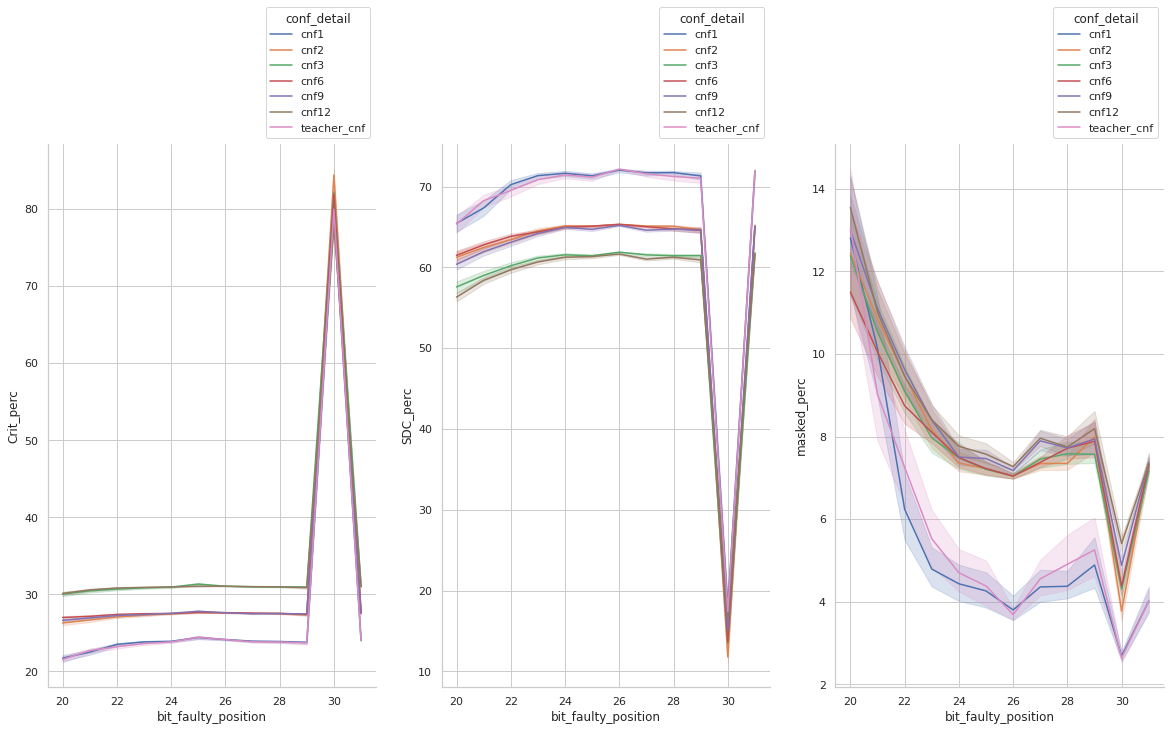

In [57]:
fig, ax = plt.subplots(1,3, figsize=(20,10))
sns.despine(fig)
sns.lineplot(data=general_report, x='bit_faulty_position', y='Crit_perc', ax=ax[0], hue ='conf_detail')
sns.move_legend(ax[0], "lower right", bbox_to_anchor=(1, 1))
# ax[0].grid()
sns.lineplot(data=general_report, x='bit_faulty_position', y='SDC_perc', ax=ax[1],hue ='conf_detail')
sns.move_legend(ax[1], "lower right", bbox_to_anchor=(1, 1))
# ax[1].grid()
sns.lineplot(data=general_report, x='bit_faulty_position', y='masked_perc', ax=ax[2], hue ='conf_detail')
sns.move_legend(ax[2], "lower right", bbox_to_anchor=(1, 1))
# ax[2].grid()

REMEMBER THE SCALING FACTOR THAT WE USED TO IMPROVE BOTH THE WEIGHT OF THE MODEL AND THE ACCURACY OF THE MODEL (WE SCALED THE NUMBER OF FILTERS PER LAYER OF A FATOR 0.15)

In [58]:
general_report.columns

Index(['layer', 'kernel', 'channel', 'row', 'col', 'bitmask',
       'global_gold_acc', 'global_gold_f1@1', 'global_fault_acc',
       'global_fault_f1@1', 'mask_Crit', 'mask_SDC', 'mask_Masked', 'Layer',
       'Ffree_Weight', 'Faulty_weight', 'Abs_error', 'conf_detail',
       'bit_faulty_position', 'Crit_perc', 'SDC_perc', 'masked_perc'],
      dtype='object')

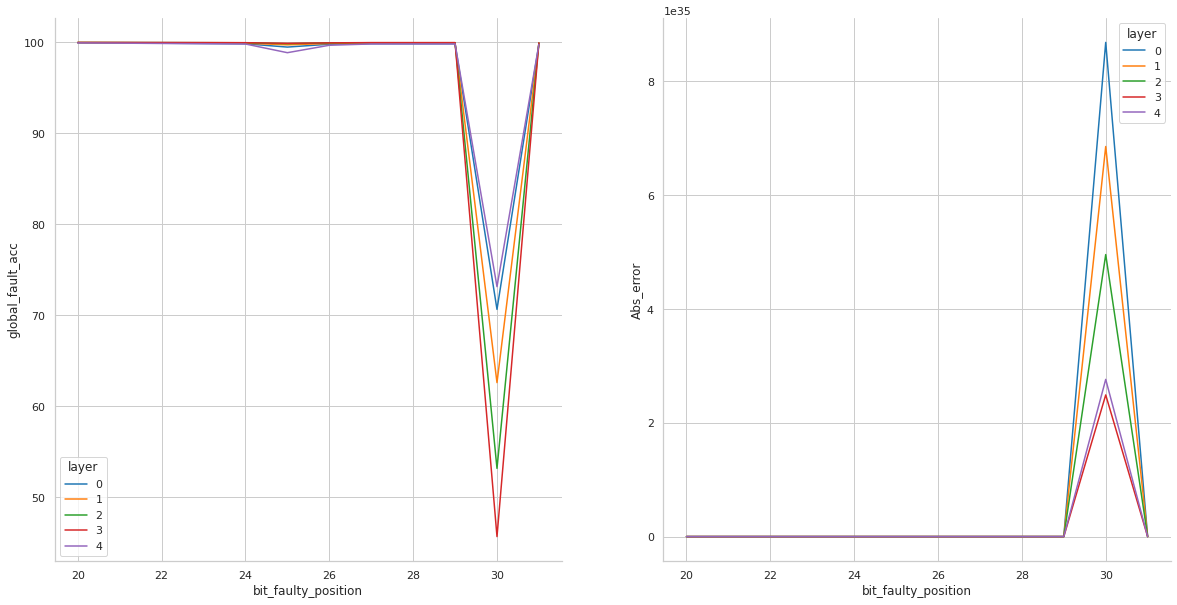

In [59]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
sns.despine(fig)
sns.lineplot(data=general_report, x='bit_faulty_position', y='global_fault_acc', ax=ax[0], hue ='layer', palette="tab10", ci=None)
# ax[0].grid()
sns.lineplot(data=general_report, x='bit_faulty_position', y='Abs_error', ax=ax[1], hue ='layer', palette="tab10", ci=None)
# ax[1].grid()

In [60]:
to_melt = general_report[['layer','Crit_perc', 'SDC_perc', 'masked_perc']]
df_melted = to_melt.melt(id_vars='layer', var_name='mask_type', value_name='mask_perc')

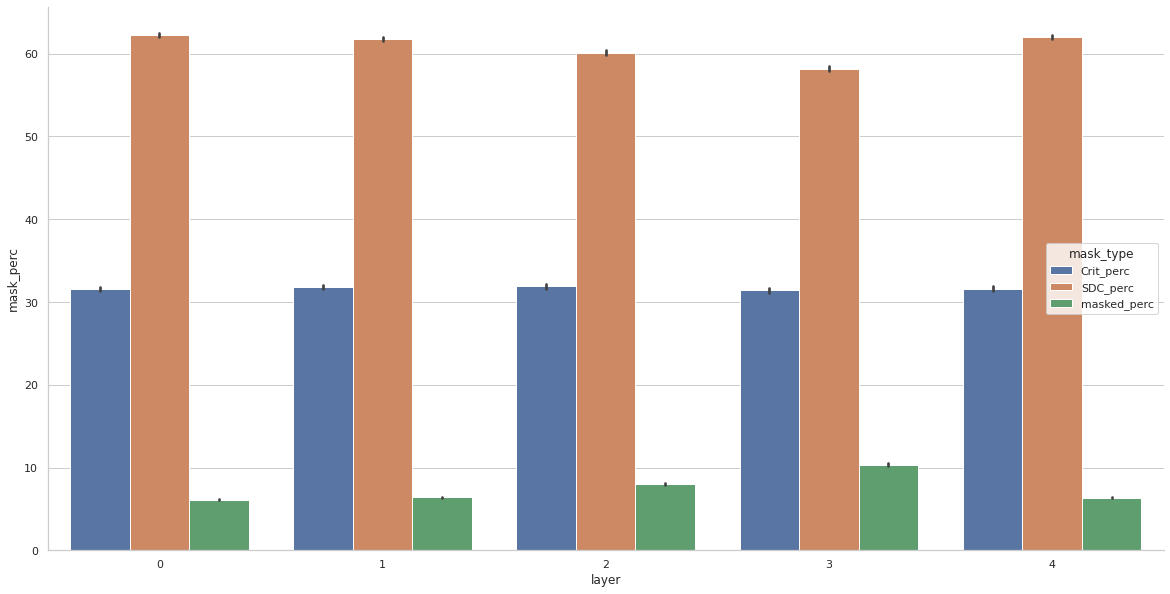

In [61]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.despine(fig)
sns.barplot(x='layer', y='mask_perc', hue='mask_type', data=df_melted, ax=ax)

In [62]:
general_report.columns

Index(['layer', 'kernel', 'channel', 'row', 'col', 'bitmask',
       'global_gold_acc', 'global_gold_f1@1', 'global_fault_acc',
       'global_fault_f1@1', 'mask_Crit', 'mask_SDC', 'mask_Masked', 'Layer',
       'Ffree_Weight', 'Faulty_weight', 'Abs_error', 'conf_detail',
       'bit_faulty_position', 'Crit_perc', 'SDC_perc', 'masked_perc'],
      dtype='object')

(0.0, 100.0)

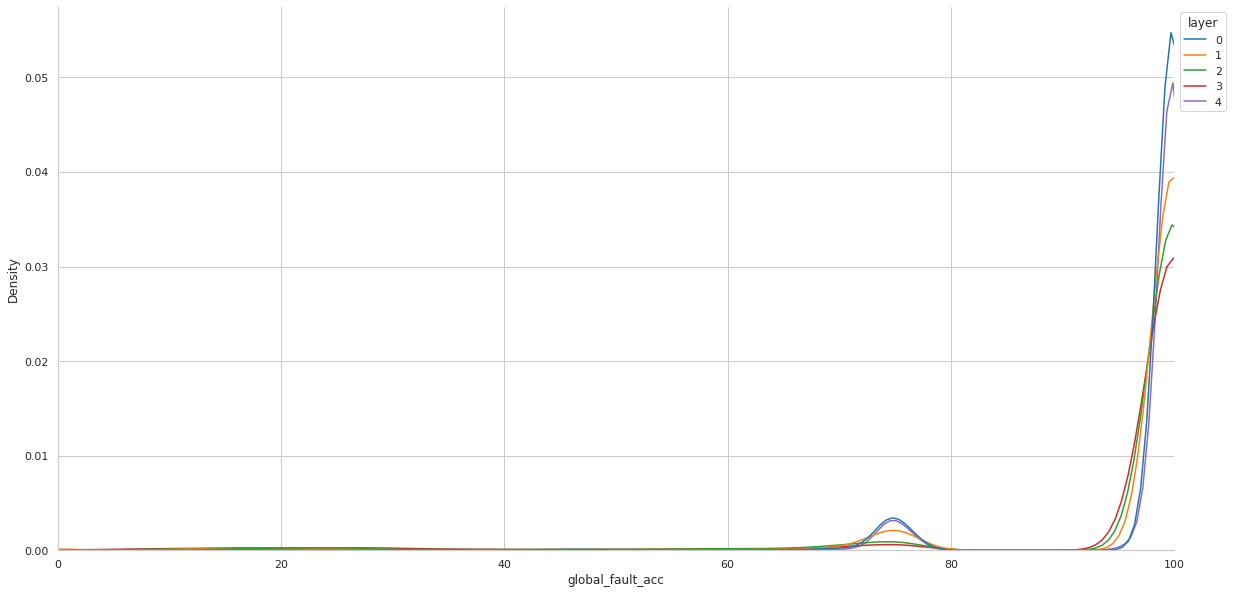

In [63]:
clustering_df = general_report[['conf_detail', 'global_fault_acc', 'bit_faulty_position', 'global_fault_f1@1', 'layer']]
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.despine(fig)
sns.kdeplot(x = 'global_fault_acc', data=clustering_df, hue = 'layer', palette="tab10")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlim(0, 100)

This behaviour is not easy to understand because the criticality relies on a global accuracy and the check of the correspondance between the labels predicted by the golden and the faulty model.

It seems that layer three seems to be good in understanding the object but not the position or the area of extension. 

A better reliability will be given from the f1 score. 

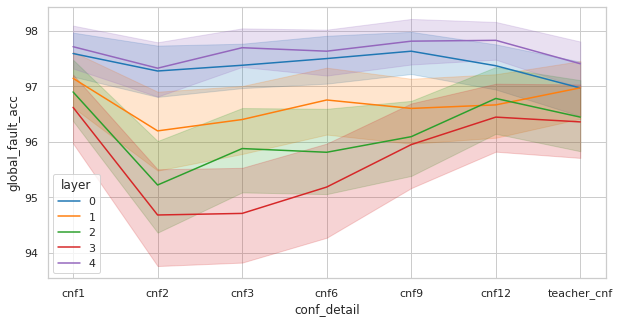

In [64]:
# Create the line plot with the sorted data
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.lineplot(x='conf_detail', y='global_fault_acc', data=general_report, hue='layer', palette='tab10')

In [65]:
general_report['global_fault_f1@1'].describe()

count    56703.000000
mean        96.888628
std         10.580255
min          0.000000
25%         98.873672
50%         99.551547
75%         99.838769
max        100.000000
Name: global_fault_f1@1, dtype: float64

(0.0, 100.0)

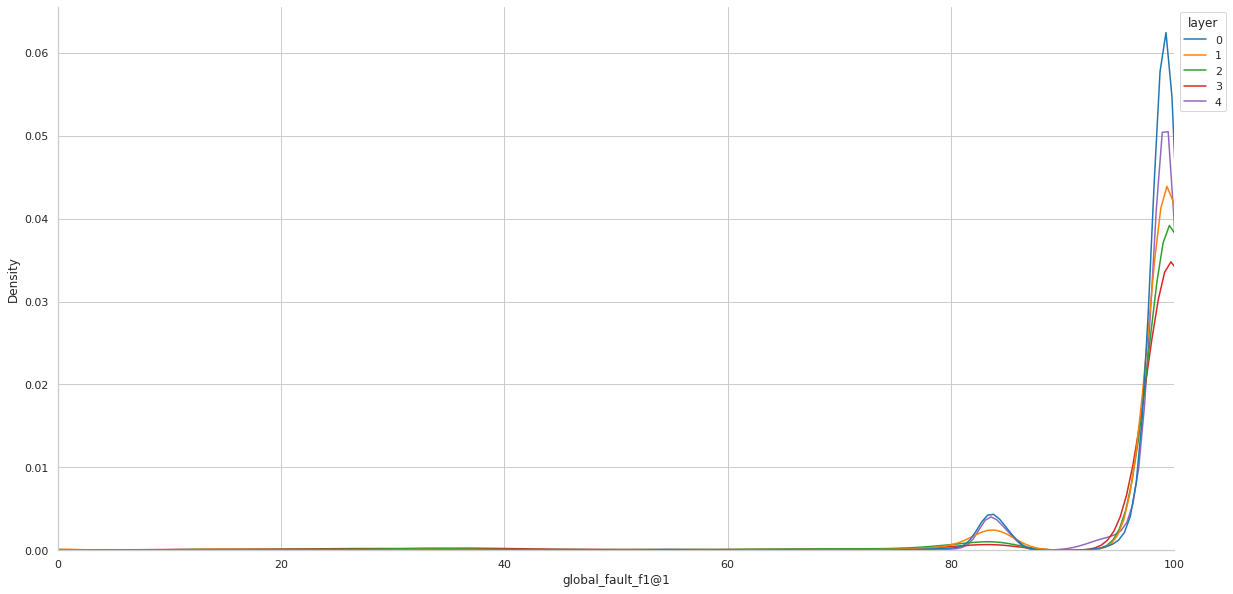

In [66]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.despine(fig)
sns.kdeplot(x = 'global_fault_f1@1', data=clustering_df, hue = 'layer', palette="tab10")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlim(0, 100)

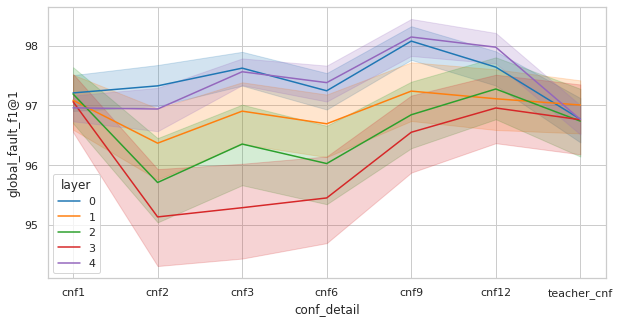

In [67]:
# Create the line plot with the sorted data
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.lineplot(x='conf_detail', y='global_fault_f1@1', data=general_report, hue='layer', palette='tab10')

In [68]:
100-general_report.groupby(by=['conf_detail', 'layer']).mean()['global_fault_f1@1'].unstack()

layer,0,1,2,3,4
conf_detail,,,,,
cnf1,2.789740,2.913282,2.807831,2.937423,3.039641
cnf2,2.671416,3.631482,4.290210,4.866690,3.059447
cnf3,2.374489,3.094807,3.645997,4.712395,2.435058
cnf6,2.753651,3.306476,3.972843,4.548752,2.617231
cnf9,1.921615,2.759309,3.155573,3.448788,1.852775
cnf12,2.357396,2.887525,2.723975,3.042014,2.023526
teacher_cnf,3.229565,2.991926,3.262353,3.238370,3.233650


In [69]:
100-general_report.groupby(by=['conf_detail', 'layer']).mean()['global_fault_acc'].unstack()

layer,0,1,2,3,4
conf_detail,,,,,
cnf1,2.410020,2.856439,3.102204,3.379844,2.286853
cnf2,2.724498,3.803135,4.777614,5.317718,2.673681
cnf3,2.621129,3.598444,4.121335,5.289182,2.304964
cnf6,2.500639,3.246541,4.188114,4.814446,2.367797
cnf9,2.367863,3.398468,3.907162,4.049685,2.187220
cnf12,2.629644,3.334991,3.218936,3.555034,2.171843
teacher_cnf,3.030851,3.027552,3.555112,3.641326,2.594084


In [70]:
general_report['SDC_Crit_masks'] = general_report['mask_Crit'] + general_report['mask_SDC'] + general_report['mask_Masked']
new_grouped_df = general_report.groupby(['layer', 'conf_detail']).sum().unstack()['SDC_Crit_masks']

detailed_report['expected_label'] = False
f_surclasses_idxs = detailed_report.query("f_label_area.isnull() and not g_label_area.isnull()").index
detailed_report['expected_label'].loc[f_surclasses_idxs] = True
new_df = detailed_report.loc[f_surclasses_idxs]
grouped = new_df[new_df['expected_label']].groupby(['layer', 'conf_detail']).size().unstack()

percentage_groups = grouped/new_grouped_df

/home/g.esposito/miniconda3/envs/sc2-benchmark/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


No handles with labels found to put in legend.


Text(0.5, 1.0, 'Probability that the golden labels are not predicted also by the faulty model')

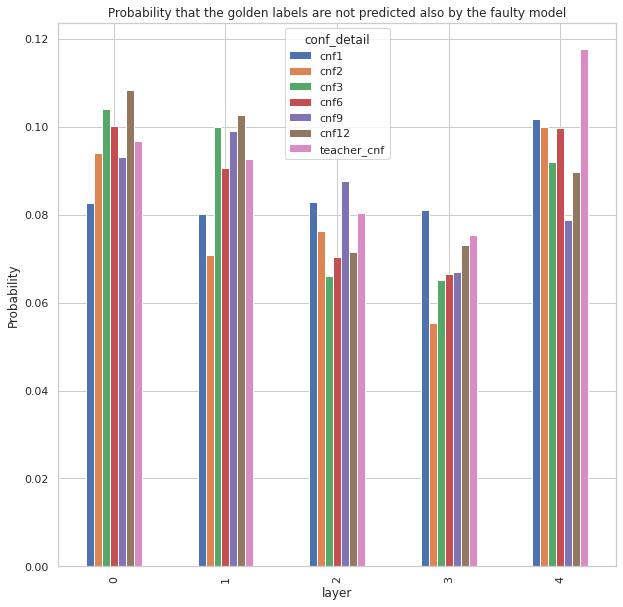

In [71]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.set_xlabel('layer')
ax.set_ylabel('Probability')
ax.legend(title='conf_detail')
# ax.set_xticklabels([1,2,3,4],rotation=90)
percentage_groups.plot(kind='bar', ax = ax, grid=True)
plt.title('Probability that, considering only sdc and critical boxes, the golden labels are not predicted also by the faulty model')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Probability that the golden labels are predicted also by the faulty model')

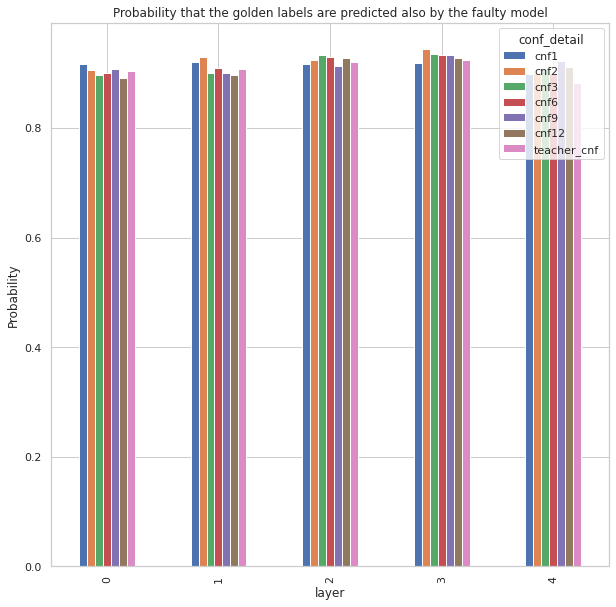

In [72]:
complementary_percentage_groups = 1-percentage_groups
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.set_xlabel('layer')
ax.set_ylabel('Probability')
ax.legend(title='conf_detail')
# ax.set_xticklabels([1,2,3,4],rotation=90)
complementary_percentage_groups.plot(kind='bar', ax = ax, grid=True)
plt.title('Probability that, considering only sdc and critical boxes, the golden labels are predicted also by the faulty model')

In [73]:
general_report['SDC_Crit_masks'] = general_report['mask_Crit'] + general_report['mask_SDC'] + general_report['mask_Masked']
new_grouped_df = general_report.groupby(['layer', 'conf_detail']).sum().unstack()['SDC_Crit_masks']

detailed_report['expected_label'] = False
f_surclasses_idxs = detailed_report.query("g_label_area.isnull() and not f_label_area.isnull()").index
detailed_report['expected_label'].loc[f_surclasses_idxs] = True
new_df = detailed_report.loc[f_surclasses_idxs]
grouped = new_df[new_df['expected_label']].groupby(['layer', 'conf_detail']).size().unstack()

percentage_groups = grouped/new_grouped_df

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Probability that the faulty labels are not predicted also by the golden model')

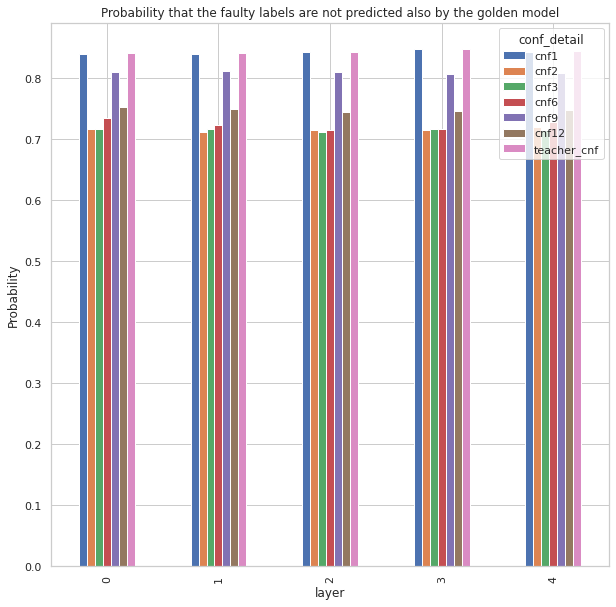

In [74]:
complementary_percentage_groups = 1-percentage_groups
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.set_xlabel('layer')
ax.set_ylabel('Probability')
ax.legend(title='conf_detail')
# ax.set_xticklabels([1,2,3,4],rotation=90)
complementary_percentage_groups.plot(kind='bar', ax = ax, grid=True)
plt.title('Probability that, considering only sdc and critical boxes, the faulty labels are not expected also by the golden model')